In [1]:
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Install Spark 3.4.1 (a newer valid version)
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!mv spark-3.4.1-bin-hadoop3 /usr/local/spark

# Install findspark
!pip install -q findspark



In [47]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 26.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"

findspark.init()


In [4]:
!pip install -q pyspark pandas matplotlib

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType


In [7]:
# Start Spark session
spark = SparkSession.builder.appName("AirQualityPrediction").getOrCreate()

## Data Preprocessing

## Load Dataset

In [24]:
# Load CSV data
df = spark.read.csv("/content/aqi_data.csv", header=True, inferSchema=True)

In [25]:
df.show()

+--------------------+----------------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+---------------+------------------+--------+---------+
|             Country|            City|AQI Value|AQI Category|CO AQI Value|CO AQI Category|Ozone AQI Value|Ozone AQI Category|NO2 AQI Value|NO2 AQI Category|PM2.5 AQI Value|PM2.5 AQI Category|     lat|      lng|
+--------------------+----------------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+---------------+------------------+--------+---------+
|  Russian Federation|      Praskoveya|       51|    Moderate|           1|           Good|             36|              Good|            0|            Good|             51|          Moderate| 44.7444|  44.2031|
|              Brazil|Presidente Dutra|       41|        Good|           1|           Good|              5|              Good|            1|            

In [26]:
df_clean = df.dropna()

df_clean = df.withColumnRenamed("PM2.5 AQI Value", "PM25") \
                     .withColumnRenamed("Ozone AQI Value", "Ozone") \
                     .withColumnRenamed("NO2 AQI Value", "NO2") \
                     .withColumnRenamed("AQI Value", "AQI")

features = ['PM25', 'Ozone', 'NO2']
target = 'AQI'

In [27]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- AQI Value: integer (nullable = true)
 |-- AQI Category: string (nullable = true)
 |-- CO AQI Value: integer (nullable = true)
 |-- CO AQI Category: string (nullable = true)
 |-- Ozone AQI Value: integer (nullable = true)
 |-- Ozone AQI Category: string (nullable = true)
 |-- NO2 AQI Value: integer (nullable = true)
 |-- NO2 AQI Category: string (nullable = true)
 |-- PM2.5 AQI Value: integer (nullable = true)
 |-- PM2.5 AQI Category: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)



In [28]:
# Assemble features into a feature vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df_clean)

# Normalize features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

## Model Building

In [57]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Split the data into training and test sets
train_data, test_data = df_scaled.randomSplit([0.7, 0.3], seed=42)

# Initialize the model
lr = LinearRegression(featuresCol='scaledFeatures', labelCol=target)

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R Squared (R²): {r2}")

Root Mean Squared Error (RMSE): 7.11796842058702
R Squared (R²): 0.9722178514372996


## Initializing additional models

In [58]:
rf = RandomForestRegressor(featuresCol='scaledFeatures', labelCol=target)
dt = DecisionTreeRegressor(featuresCol='scaledFeatures', labelCol=target)

# Train the RandomForest model
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_rmse = evaluator.evaluate(rf_predictions)
rf_r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

# Train the DecisionTree model
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_rmse = evaluator.evaluate(dt_predictions)
dt_r2 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "r2"})

print(f"Linear Regression RMSE: {rmse}, R²: {r2}")
print(f"Random Forest RMSE: {rf_rmse}, R²: {rf_r2}")
print(f"Decision Tree RMSE: {dt_rmse}, R²: {dt_r2}")

Linear Regression RMSE: 7.11796842058702, R²: 0.9722178514372996
Random Forest RMSE: 18.59302425774655, R²: 0.8104369065072682
Decision Tree RMSE: 15.218693391188356, R²: 0.8729986169490911


## Visualization

Text(0.5, 1.0, 'Linear Regression')

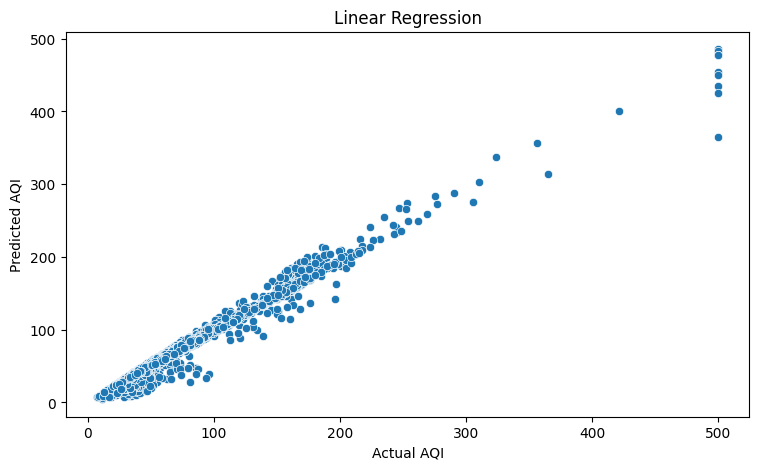

In [59]:
# Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to Pandas DataFrame
lr_predictions_pd = predictions.select("prediction", target).toPandas()
rf_predictions_pd = rf_predictions.select("prediction", target).toPandas()
dt_predictions_pd = dt_predictions.select("prediction", target).toPandas()

# Plot predicted vs actual values
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=lr_predictions_pd[target], y=lr_predictions_pd['prediction'])
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Linear Regression')

Text(0.5, 1.0, 'Random Forest')

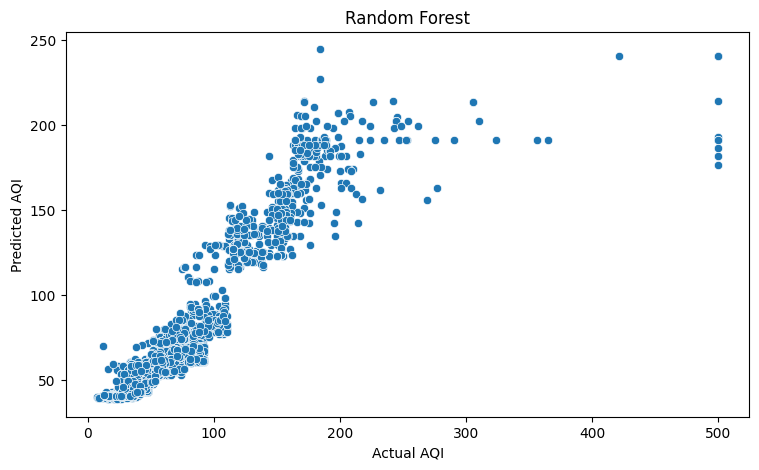

In [60]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 2)
sns.scatterplot(x=rf_predictions_pd[target], y=rf_predictions_pd['prediction'])
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Random Forest')

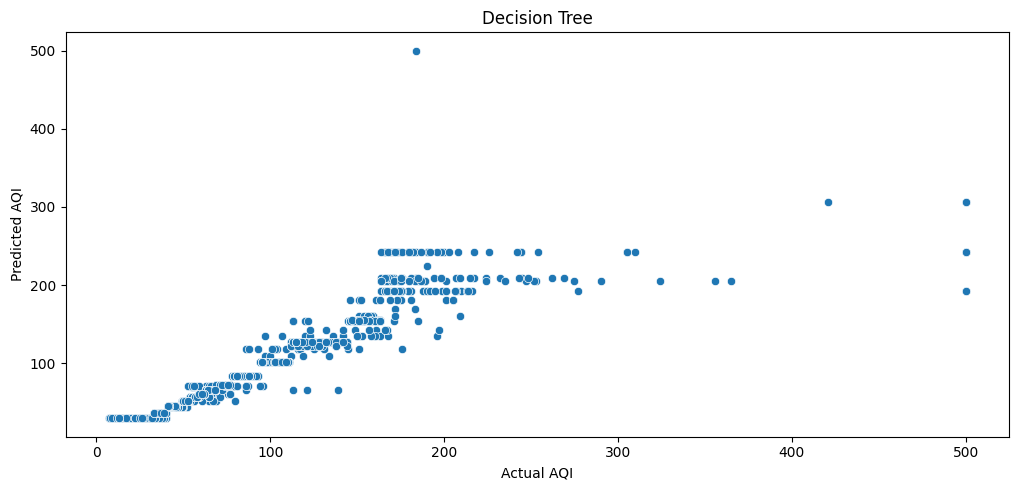

In [61]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 3)
sns.scatterplot(x=dt_predictions_pd[target], y=dt_predictions_pd['prediction'])
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Decision Tree')

plt.tight_layout()
plt.show()

## Further processing

# Hyperparameter tuning for the RandomForestRegressor

In [63]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

# Assuming df_scaled and target are already defined in the context

# Hyperparameter tuning for RandomForestRegressor
rf = RandomForestRegressor(featuresCol='scaledFeatures', labelCol=target)

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .build())

# TrainValidationSplit for hyperparameter tuning
trainValidationSplit = TrainValidationSplit(estimator=rf,
                                             estimatorParamMaps=paramGrid,
                                             evaluator=RegressionEvaluator(labelCol=target),
                                             trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
rf_model = trainValidationSplit.fit(train_data)

## Feature importance analysis

In [64]:
# Feature Importance
best_rf_model = rf_model.bestModel
feature_importances = best_rf_model.featureImportances
print("Feature Importances:", feature_importances)

# Additional Data Preprocessing (if needed)
# Example: Log transformation of a feature
# df_scaled = df_scaled.withColumn('log_PM2.5', log(df_scaled['PM2.5']))

# Note: Ensure to import necessary libraries and define any additional preprocessing steps as needed.

Feature Importances: (3,[0,1,2],[0.7601406516116672,0.1688271499870503,0.07103219840128258])


## Thank You